In [1]:
import json
import numpy as np
import pylcs
from collections import Counter, defaultdict
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import random
import spacy
from sklearn.cluster import AgglomerativeClustering, KMeans
from nltk.corpus import stopwords
import torch
nlp = spacy.load("en_core_web_sm", disable=["ner","textcat","parser"])

In [2]:
from word2number import w2n
def toNum(word):
    try: return w2n.word_to_num(word)
    except:
        return word

In [3]:
# This version has NO lemmatization.
# normalize_text for eval needs lemmatization
def normalize_text(s):
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)

    def white_space_fix(text): # additional: converting numbers to digit form
        return " ".join([str(toNum(w)) for w in text.split()])
        #return " ".join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation) - set(['.'])
        text1 = "".join(ch for ch in text if ch not in exclude)
        return re.sub(r"\.(?!\d)", "", text1)

    def lower(text):
        return text.lower()
    
    #def lemmatization(text):
        #return " ".join([token.lemma_ for token in nlp(text)])
    if len(s.strip()) == 1:
        # FIXME: Is there a more general solution for handling answers like "+", "The"
        return white_space_fix(lower(s))
    if len(s.strip().split()) == 1: 
        return white_space_fix(remove_punc(lower(s)))
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [5]:
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0820_addKA.json", "r"))

print(Counter([len(txt_dataset[j]['txt_posFacts']) for j in txt_dataset]))
print(Counter([txt_dataset[j]['split'] for j in txt_dataset]))

Counter({2: 24030, 3: 882, 4: 46, 1: 3, 5: 1})
Counter({'train': 17812, 'test': 4695, 'val': 2455})


24962


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


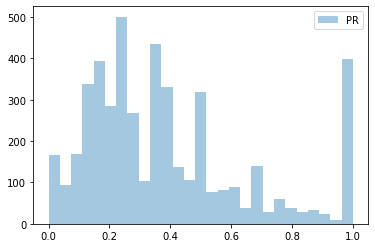

In [10]:
import pylcs
print(len(txt_dataset))
overlap_ratio_list = []
id2ratio = {}
for k in txt_dataset:
    if not txt_dataset[k]['split'] == 'test': continue
    A = normalize_text(txt_dataset[k]['Keywords_A'].replace('"', ''))
    B = normalize_text(txt_dataset[k]['Q'].replace('"', ''))
    overlap_ratio = pylcs.lcs2(B, A) / len(A)
    id2ratio[k] = overlap_ratio
    overlap_ratio_list.append(overlap_ratio)

sns.distplot(overlap_ratio_list, kde=False, label="PR")
plt.legend()

In [13]:
print(len(id2ratio))
txt_dataset_Qcate = copy.deepcopy(txt_dataset)
Qcate_dict = defaultdict(lambda: [])
used_k = []
for k in txt_dataset:
    if not txt_dataset[k]['split'] == 'test': 
        txt_dataset_Qcate[k]['Qcate'] = 'TBD'
        continue
    normalized_A = normalize_text(txt_dataset[k]['Keywords_A'].replace('"', ''))
    if id2ratio[k] > 0.8 and (not "what" in txt_dataset[k]['Q'].lower()) and (len(normalized_A) > 1) and (not "no" == normalized_A) and (not normalized_A == "yes"):
        txt_dataset_Qcate[k]['Qcate'] = 'choose'
        Qcate_dict['choose'].append(k)
    else:
        txt_dataset_Qcate[k]['Qcate'] = 'Others'
        Qcate_dict['Others'].append(k)
    
    ### dataset_J_Qcate[k]['Guid'] = uuid.uuid1().hex # Guid was generated for img data on Jun 23. Never need to run this line again unless it's really necessary

for cate in Qcate_dict:
    print(cate, len(Qcate_dict[cate]))
print(Counter([txt_dataset_Qcate[k]['Qcate'] for k in txt_dataset_Qcate]))
print(len(set([txt_dataset_Qcate[k]['Guid'] for k in txt_dataset_Qcate])))

4695
Others 4326
choose 369
Counter({'TBD': 20267, 'Others': 4326, 'choose': 369})
24962


In [22]:
for k in txt_dataset:
    if not k in id2ratio: continue
    normalized_A = normalize_text(txt_dataset[k]['Keywords_A'].replace('"', ''))
    if 0.8<id2ratio[k] <=0.85 and (not "what" in txt_dataset[k]['Q'].lower()) and (len(normalized_A) > 1) and (not "no" == normalized_A) and (not normalized_A == "yes"):
        if random.random() > 0.2: continue
        print()
        print(id2ratio[k])
        pprint(txt_dataset[k]['Q'])
        pprint(txt_dataset[k]['A'])
        pprint(txt_dataset[k]['Keywords_A'])


0.8181818181818182
'Whose father had a longer first name: Micheal O Domhnaill or Michael Ce?'
["Michael Che's father had a longer first name.",
 '"Michael Che\'s father had a longer first name."',
 '"Michael Che\'s father had a longer first name than the father of Micheal O '
 'Domhnaill."',
 '"Michael Ce\'s father had a longer name than Micheal O Domhnaill\'s father."',
 '"Micheal Che\'s father has a longer first name then does Mícheál Ó '
 'Domhnaill\'s father."']
'"Michael Che"'

0.8333333333333334
('How many years after the Cwmorthin Quarry was connected to the Ffestiniog '
 'Railway did the Cwmorthin Slate Company become incorporated?')
['It took one year for the Cwmorthin Slate Company to incorporate in 1861 '
 'after the Cwmorthin Quarry finally was connected to the Ffestiniog Railway '
 'in 1860.',
 '"The Cwmorthin Slate Company became incorporated in 1861, one year after the '
 'Cwmorthin Quarry was connected to the Ffestiniog Railway in 1860."',
 '"It says that Cwmorthin qua

In [14]:
for k in random.sample(list(Qcate_dict['choose']), 10):
    print()
    pprint(txt_dataset_Qcate[k]['Q'])
    pprint(txt_dataset_Qcate[k]['A'])
    pprint(txt_dataset_Qcate[k]['Keywords_A'])


('Are Lucanus cervus and Lucanus capreolus found on the same continent or '
 'different continents?')
['Different, as cervus is found in Europe and capreolus is found in N. '
 'America.',
 '"Lucanus cervus and Lucanus capreolus are found on different continents."',
 '"Lucanus cervus and Lucanus capreolus found on different continents."',
 '"Lucanus cervus and Lucanus capreolus are found in different continents."',
 '"Lucanus cervus and Lucanus capreolus can be found on different continents"']
'"Different continents"'

('In which could you get a more widely recognized education; Hyde Park or '
 'Vanderbilt University')
['Vanderbilt University',
 '"You could get a more widely recognized education at Vanderbilt University '
 'than at Hyde Park, given that Hyde Park is a mansion and historic site, not '
 'a university."',
 '"Vanderbilt University is a private research university, and thus provides '
 'education. Hyde Park is not a school of any kind, and therefore one could '
 'not get an